### Universidade Federal do Tocantins
#### Curso: Ciência da Computação
#### Disciplina: Redes Neurais e Aprendizado Profundo (Deep Learning)
#### Professor: Dr. Marcelo Lisboa Rocha
#### Acadêmico: Antonio André Bacelos Chagas

##### Construção de um modelo CNN para detecção de tumores cerebrais a partir de imagens de ressonância magnética (MRI) utilizando EfficientNetB0.

##### Dataset utilizado: [Kaggle Brain Tumor MRI](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset).

### Conexão com o Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Configuração de Ambiente e Importações

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers, models
from keras.applications import EfficientNetB0
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from pathlib import Path

# Configurar diretórios (Mantendo sua lógica original)
possible_base_dirs = [
    Path("/content/drive/MyDrive/Colab Notebooks/trabalho_final"),
    Path.cwd(),
]

base_dir = None
for candidate in possible_base_dirs:
    candidate = candidate.expanduser().resolve()
    if (candidate / "Training").is_dir():
        base_dir = candidate
        break

if base_dir:
    train_dir = base_dir / "Training"
    test_dir = base_dir / "Testing"
    print(f"Diretórios definidos: {train_dir}")
    print(f"Diretórios definidos: {test_dir}")


    # Diretório para salvar modelos
    checkpoints_dir = os.path.join(base_dir, "checkpoints_modelo")
    os.makedirs(checkpoints_dir, exist_ok=True)
    modelo_final_salvo_path = os.path.join(checkpoints_dir, "brain_tumor_classifier_optimized.keras")

Diretórios definidos: /content/drive/MyDrive/Colab Notebooks/trabalho_final/Training
Diretórios definidos: /content/drive/MyDrive/Colab Notebooks/trabalho_final/Testing


### Carregamento e Pré-processamento de Dados

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
COLOR_MODE = 'rgb'

print("Carregando datasets com resolução 224x224...")

train_dataset = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=42,
    label_mode='categorical',
    color_mode=COLOR_MODE,
    shuffle=True
)

validation_dataset = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42,
    label_mode='categorical',
    color_mode=COLOR_MODE,
    shuffle=True
)

test_dataset = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    color_mode=COLOR_MODE,
    shuffle=False
)

class_names = train_dataset.class_names
print(f"Classes: {class_names}")

# Otimização de performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Carregando datasets com resolução 224x224...
Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


### Construção da Arquitetura do Modelo

In [4]:
def create_optimized_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape + (3,), name="input_layer")

    # Data Augmentation (Leve para não distorcer características médicas)
    x = layers.RandomRotation(0.05)(inputs)
    x = layers.RandomZoom(0.1)(x)
    x = layers.RandomFlip("horizontal")(x)

    # Carregar modelo base (Transfer Learning)
    base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=x)

    # FASE 1: Congelar o modelo base completamente
    base_model.trainable = False

    # Reconstruir o classificador (Head)
    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.BatchNormalization()(x)

    x = layers.Dropout(0.3)(x) # Dropout para evitar overfitting
    x = layers.Dense(512, activation="relu")(x) # Camada densa robusta
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    model = models.Model(inputs, outputs, name="Brain_Tumor_EfficientNet")
    return model

# Criar o modelo
model = create_optimized_model(IMG_SIZE, num_classes=len(class_names))
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Brain_Tumor_EfficientNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom         │ (None, 224, 224,  │          0 │ random_rotation[… │
│ (RandomZoom)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 224, 224,  │          0 │ random_zoom[0][0] │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ random_flip[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha

 Total params: 4,714,663 (17.99 MB)

 Trainable params: 661,508 (2.52 MB)

 Non-trainable params: 4,053,155 (15.46 MB)

### Fase 1: Treinamento do Classificador (Feature Extraction)

In [12]:
print("\n=== FASE 1: Treinando o classificador (Base congelada) ===")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks_phase1 = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1),
]

history_1 = model.fit(
    train_dataset,
    epochs=12, # Poucas épocas para ajustar o topo
    validation_data=validation_dataset,
    callbacks=callbacks_phase1
)


=== FASE 1: Treinando o classificador (Base congelada) ===
Epoch 1/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 551s 3s/step - accuracy: 0.7405 - loss: 0.8546 - val_accuracy: 0.8205 - val_loss: 0.4890
Epoch 2/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 510s 3s/step - accuracy: 0.8761 - loss: 0.3570 - val_accuracy: 0.8730 - val_loss: 0.3584
Epoch 3/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 484s 3s/step - accuracy: 0.8809 - loss: 0.3197 - val_accuracy: 0.8660 - val_loss: 0.3696
Epoch 4/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 485s 3s/step - accuracy: 0.9048 - loss: 0.2743 - val_accuracy: 0.8949 - val_loss: 0.3133
Epoch 5/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 548s 4s/step - accuracy: 0.8901 - loss: 0.2572 - val_accuracy: 0.8870 - val_loss: 0.3316
Epoch 6/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 492s 3s/step - accuracy: 0.9170 - loss: 0.2401 - val_accuracy: 0.8975 - val_loss: 0.3003
Epoch 7/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 485s 3s/step - accuracy: 0.9194 - loss: 0.2021 - val_accuracy: 0.8949 - val_loss: 0.3302
Epoch 8/12
143/143 ━━━━━━━━━━━━━━━━━━

### Fase 2: Fine-Tuning (Descongelar e Refinar)

In [13]:
print("\n=== FASE 2: Fine-Tuning (Ajuste fino da rede completa) ===")

# Descongelar o modelo base para permitir que ele aprenda características do cérebro
# Acesso a camada do EfficientNet (geralmente é a layer[3] ou [4] devido ao augmentation)
for layer in model.layers:
    if isinstance(layer, keras.Model): # Encontra o backbone EfficientNet
        layer.trainable = True

        for sub_layer in layer.layers:
            if isinstance(sub_layer, layers.BatchNormalization):
                sub_layer.trainable = False

# Recompilar com Learning Rate MUITO BAIXA (1e-5)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks_phase2 = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ModelCheckpoint(filepath=modelo_final_salvo_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

# Treinar por mais épocas, começando de onde parou na célula anterior
history_2 = model.fit(
    train_dataset,
    epochs=35,
    initial_epoch=history_1.epoch[-1],
    validation_data=validation_dataset,
    callbacks=callbacks_phase2
)

# Salvar o Histórico
import pickle

history_path = os.path.join(checkpoints_dir, "history_optimized.pkl")
with open(history_path, 'wb') as f:
    pickle.dump({
        'history_1': history_1.history,
        'history_2': history_2.history
    }, f)
print(f"Histórico de treinamento salvo em: {history_path}")


=== FASE 2: Fine-Tuning (Ajuste fino da rede completa) ===
Epoch 12/35
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9364 - loss: 0.1772
Epoch 12: val_accuracy improved from -inf to 0.92119, saving model to /content/drive/MyDrive/Colab Notebooks/trabalho_final/checkpoints_modelo/brain_tumor_classifier_optimized.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 530s 4s/step - accuracy: 0.9364 - loss: 0.1772 - val_accuracy: 0.9212 - val_loss: 0.2407 - learning_rate: 1.0000e-05
Epoch 13/35
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9401 - loss: 0.1610
Epoch 13: val_accuracy improved from 0.92119 to 0.92207, saving model to /content/drive/MyDrive/Colab Notebooks/trabalho_final/checkpoints_modelo/brain_tumor_classifier_optimized.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 500s 3s/step - accuracy: 0.9402 - loss: 0.1610 - val_accuracy: 0.9221 - val_loss: 0.2402 - learning_rate: 1.0000e-05
Epoch 14/35
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9414 - loss: 0.1642
Epoch 14: val_accuracy 

### Visualização dos Resultados

Carregando histórico salvo do disco...


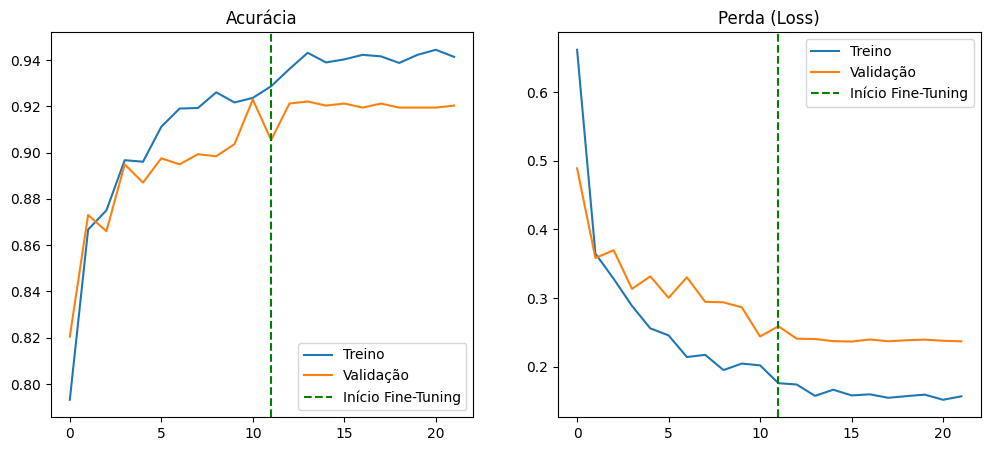

In [5]:
import pickle

# Carrega o histórico
history_path = os.path.join(checkpoints_dir, "history_optimized.pkl")

# Classe auxiliar para simular o objeto History do Keras
class HistoryMock:
    def __init__(self, history_dict):
        self.history = history_dict

# Verifica se history_1 ou history_2 não estão definidos
if 'history_1' not in globals() or 'history_2' not in globals():
    if os.path.exists(history_path):
        print("Carregando histórico salvo do disco...")
        with open(history_path, 'rb') as f:
            histories = pickle.load(f)
            history_1 = HistoryMock(histories['history_1'])
            history_2 = HistoryMock(histories['history_2'])
    else:
        print("AVISO: Histórico não encontrado e variáveis não definidas. Execute o treinamento primeiro.")
        history_1 = None
        history_2 = None

# Unir históricos para plotagem
def plot_full_history(h1, h2):
    if h1 is None or h2 is None:
        print("Históricos não disponíveis para plotagem.")
        return

    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Treino')
    plt.plot(val_acc, label='Validação')
    plt.axvline(x=len(h1.history['accuracy'])-1, color='green', linestyle='--', label='Início Fine-Tuning')
    plt.title('Acurácia')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Treino')
    plt.plot(val_loss, label='Validação')
    plt.axvline(x=len(h1.history['loss'])-1, color='green', linestyle='--', label='Início Fine-Tuning')
    plt.title('Perda (Loss)')
    plt.legend()
    plt.show()

plot_full_history(history_1, history_2)

### Avaliação e Métricas


=== Avaliação final no Teste ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 170s 4s/step - accuracy: 0.8839 - loss: 0.3078
              precision    recall  f1-score   support

      glioma       0.94      0.86      0.90       300
  meningioma       0.88      0.82      0.85       306
     notumor       0.98      0.98      0.98       405
   pituitary       0.87      1.00      0.93       300

    accuracy                           0.92      1311
   macro avg       0.92      0.92      0.91      1311
weighted avg       0.92      0.92      0.92      1311



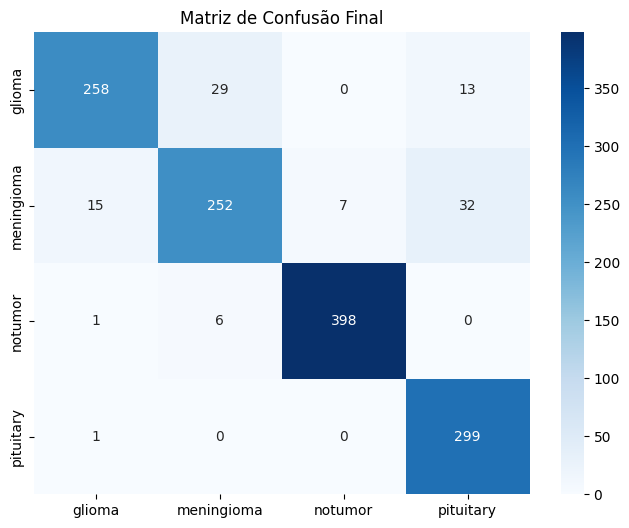

In [10]:
print("\n=== Avaliação final no Teste ===")
# Carregar o melhor modelo salvo pelo Checkpoint da Fase 2
model.load_weights(modelo_final_salvo_path)

# Recompilar o modelo após carregar os pesos, com as mesmas configurações de compilação da Fase 2
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.evaluate(test_dataset)

# Matriz de Confusão e Report
y_pred = []
y_true = []
for img, label in test_dataset:
    pred = model.predict(img, verbose=0)
    y_pred.extend(np.argmax(pred, axis=1))
    y_true.extend(np.argmax(label.numpy(), axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Matriz de Confusão Final")
plt.show()

### Predição de Imagem Única

=== Teste com Imagem Aleatória do Dataset de Teste ===
Arquivo selecionado: Te-no_0191.jpg
Classe Real (Pasta): notumor


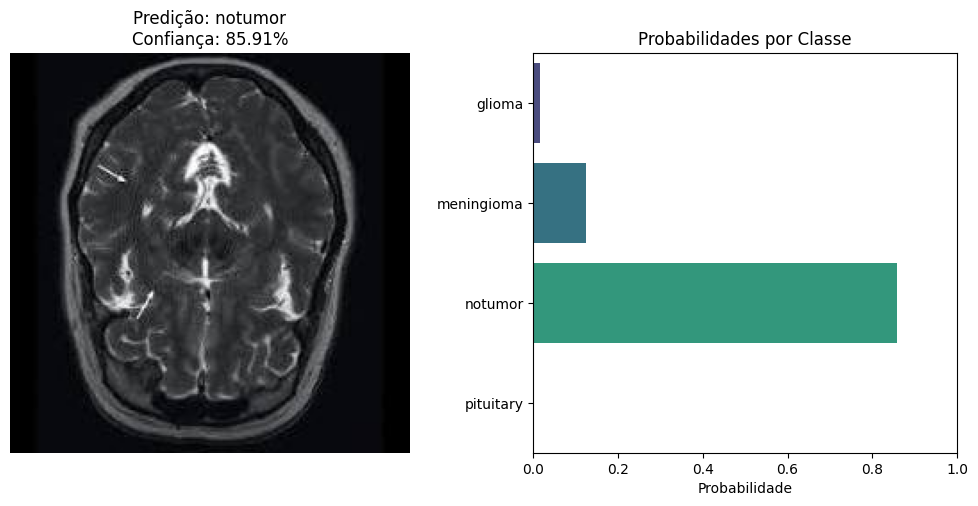

In [11]:
def predict_and_visualize(model, img_path, class_names):
    try:
        # Carregar imagem com o tamanho correto
        img = keras.utils.load_img(img_path, target_size=IMG_SIZE)
        img_array = keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Adicionar dimensão do batch

        # Predição
        predictions = model.predict(img_array, verbose=0)
        score = predictions[0]
        predicted_class_idx = np.argmax(score)
        predicted_class = class_names[predicted_class_idx]
        confidence = 100 * np.max(score)

        # Visualização
        plt.figure(figsize=(10, 5))

        # Imagem
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f"Predição: {predicted_class}\nConfiança: {confidence:.2f}%")
        plt.axis("off")

        # Gráfico de barras das probabilidades
        plt.subplot(1, 2, 2)
        sns.barplot(x=score, y=class_names, hue=class_names, palette="viridis", legend=False)
        plt.xlabel("Probabilidade")
        plt.title("Probabilidades por Classe")
        plt.xlim(0, 1)

        plt.tight_layout()
        plt.show()

        return predicted_class, confidence

    except Exception as e:
        print(f"Erro ao processar imagem {img_path}: {e}")
        return None, None


import random

print("=== Teste com Imagem Aleatória do Dataset de Teste ===")

if 'test_dir' in globals() and test_dir is not None:
    # Escolher uma classe aleatória para testar
    random_class = random.choice(class_names)
    class_path = test_dir / random_class

    # Listar imagens (suporta jpg, jpeg, png)
    if class_path.exists():
        images = list(class_path.glob("*.jpg")) + list(class_path.glob("*.jpeg")) + list(class_path.glob("*.png"))

        if images:
            random_image_path = random.choice(images)
            print(f"Arquivo selecionado: {random_image_path.name}")
            print(f"Classe Real (Pasta): {random_class}")

            predict_and_visualize(model, random_image_path, class_names)
        else:
            print(f"Nenhuma imagem encontrada em {class_path}")
    else:
        print(f"Diretório não encontrado: {class_path}")
else:
    print("Variável 'test_dir' não definida. Execute as células de configuração primeiro.")